In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

In [2]:
import json

# Function to load configurations
def load_config(config_file):
    with open(config_file, 'r') as file:
        config = json.load(file)
    return config

# Load the configuration
config = load_config('config/config.json')

# Access the dataset path
dataset_dir = config['dataset_path']
train_dir = config['train_path']
val_dir = config['val_path']
test_dir = config['test_path']

In [3]:
number_of_epochs = 30

In [4]:
# Define your CNN model
class CNN_Model(nn.Module):
    def __init__(self, dropout_rate):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(512 * 2 * 2, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [5]:
# Set the parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.00001, 0.001, 0.0001],
    'batch_size': [16, 32, 64],
    'dropout_rate': [0.3, 0.5, 0.7],
}

In [6]:
# Define transforms for train and validation data
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [7]:
# Load train and val datasets from respective folders
train_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=transform
)

val_dataset = datasets.ImageFolder(
    root=val_dir,
    transform=transform
)

In [8]:
# Define function for training and validation
def train_and_evaluate(params):
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    dropout_rate = params['dropout_rate']

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = CNN_Model(dropout_rate=dropout_rate)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training
    model.train()
    for epoch in range(number_of_epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [9]:
# Perform hyperparameter tuning
best_params, best_accuracy = None, 0
for params in ParameterGrid(param_grid):
    accuracy = train_and_evaluate(params)
    print(f"Params: {params}, Accuracy: {accuracy:.2f}%")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

print(f"Best Params: {best_params}, Best Accuracy: {best_accuracy:.2f}%")


Params: {'batch_size': 16, 'dropout_rate': 0.3, 'learning_rate': 1e-05}, Accuracy: 53.57%
Params: {'batch_size': 16, 'dropout_rate': 0.3, 'learning_rate': 0.001}, Accuracy: 60.71%
Params: {'batch_size': 16, 'dropout_rate': 0.3, 'learning_rate': 0.0001}, Accuracy: 53.57%
Params: {'batch_size': 16, 'dropout_rate': 0.5, 'learning_rate': 1e-05}, Accuracy: 35.71%
Params: {'batch_size': 16, 'dropout_rate': 0.5, 'learning_rate': 0.001}, Accuracy: 60.71%
Params: {'batch_size': 16, 'dropout_rate': 0.5, 'learning_rate': 0.0001}, Accuracy: 57.14%
Params: {'batch_size': 16, 'dropout_rate': 0.7, 'learning_rate': 1e-05}, Accuracy: 60.71%
Params: {'batch_size': 16, 'dropout_rate': 0.7, 'learning_rate': 0.001}, Accuracy: 50.00%
Params: {'batch_size': 16, 'dropout_rate': 0.7, 'learning_rate': 0.0001}, Accuracy: 75.00%
Params: {'batch_size': 32, 'dropout_rate': 0.3, 'learning_rate': 1e-05}, Accuracy: 39.29%
Params: {'batch_size': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001}, Accuracy: 42.86%
Params:

In [10]:
model = CNN_Model(dropout_rate = best_params['dropout_rate'])
optimizer = torch.optim.Adam(model.parameters(), lr = best_params['learning_rate'])
batch_size = best_params['batch_size']
criterion = torch.nn.CrossEntropyLoss() 

In [11]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [12]:
def train_model(model, criterion, optimizer, num_epochs):
    # Ensuring the model and all tensors are on the correct device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    training_accuracy_stats = []
    validation_accuracy_stats = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        train_labels = []
        train_predictions = []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            if images.dim() != 4:
                print(f"Expected 4D tensor but got {images.dim()}D tensor. Skipping batch...")
                continue
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Collect predictions and true labels for accuracy calculation
            _, predicted = torch.max(outputs, 1)
            train_labels.extend(labels.cpu().numpy())
            train_predictions.extend(predicted.cpu().numpy())

        # Calculate training accuracy
        train_accuracy = accuracy_score(train_labels, train_predictions)
        training_accuracy_stats.append(train_accuracy)

        # Evaluate on validation set
        model.eval()
        val_labels = []
        val_predictions = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                val_labels.extend(labels.cpu().numpy())
                val_predictions.extend(predicted.cpu().numpy())

        # Calculate validation accuracy
        val_accuracy = accuracy_score(val_labels, val_predictions)
        validation_accuracy_stats.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Plotting the training and validation accuracy curves
    plt.plot(range(1, num_epochs + 1), training_accuracy_stats, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve CNN PyTorch')
    plt.show()


In [13]:
# Initialize the model, loss criterion and optimizer
if torch.cuda.is_available():
    model.cuda()

Epoch 1/30, Loss: 16.7618, Train Accuracy: 0.5103, Val Accuracy: 0.4286
Epoch 2/30, Loss: 10.2306, Train Accuracy: 0.5464, Val Accuracy: 0.5714
Epoch 3/30, Loss: 9.0798, Train Accuracy: 0.5206, Val Accuracy: 0.4286
Epoch 4/30, Loss: 9.5525, Train Accuracy: 0.5206, Val Accuracy: 0.4286
Epoch 5/30, Loss: 10.3556, Train Accuracy: 0.5722, Val Accuracy: 0.5714
Epoch 6/30, Loss: 8.7987, Train Accuracy: 0.5515, Val Accuracy: 0.4286
Epoch 7/30, Loss: 9.1740, Train Accuracy: 0.6134, Val Accuracy: 0.5000
Epoch 8/30, Loss: 8.7042, Train Accuracy: 0.5979, Val Accuracy: 0.4286
Epoch 9/30, Loss: 9.2803, Train Accuracy: 0.6289, Val Accuracy: 0.5357
Epoch 10/30, Loss: 8.0968, Train Accuracy: 0.6134, Val Accuracy: 0.3929
Epoch 11/30, Loss: 8.5225, Train Accuracy: 0.6443, Val Accuracy: 0.5357
Epoch 12/30, Loss: 7.9809, Train Accuracy: 0.6649, Val Accuracy: 0.4286
Epoch 13/30, Loss: 8.2952, Train Accuracy: 0.6959, Val Accuracy: 0.6429
Epoch 14/30, Loss: 6.7147, Train Accuracy: 0.7320, Val Accuracy: 0.428

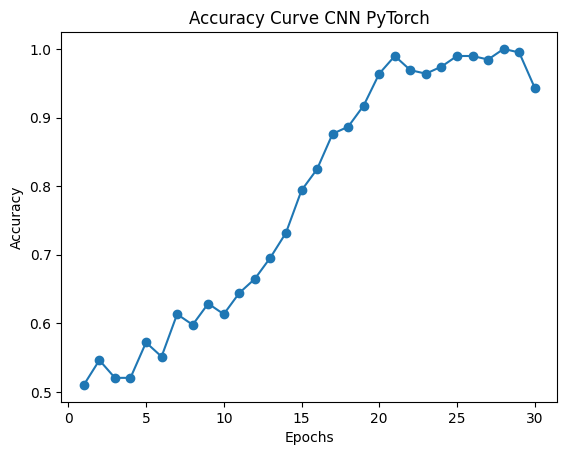

In [14]:
# Train and evaluate the model
train_model(
    model,
    criterion,
    optimizer,
    number_of_epochs
)

In [15]:
torch.save(model.state_dict(), f'Pth_Files/CNN_Pytorch_{number_of_epochs}.pth')

# Printing the results

In [16]:
def evaluate_model(model):
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    classes = train_dataset.classes

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    if len(all_labels) == 0:
        print("No data was loaded. Check your dataset and DataLoader.")
    else:
        # Calculate and print the confusion matrix
        cm = confusion_matrix(all_labels, all_predictions)
        # Plotting the confusion matrix
        plt.figure(figsize=(10,7))
        sns.heatmap(
            cm,
            annot=True,
            fmt='g',
            cmap='Blues',
            xticklabels=classes,
            yticklabels=classes
        )
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.title('Confusion Matrix CNN Pytorch')
        plt.show()

        # Calculate accuracy
        accuracy = accuracy_score(all_labels, all_predictions)
        print(f'Validation Accuracy: {accuracy * 100:.2f}%')
        
        print('\n--------------------------------\n')
        print("Classification Report CNN PyTorch:")
        accuracy = accuracy_score(all_labels, all_predictions)
        precision = precision_score(all_labels, all_predictions, average='weighted')
        recall = recall_score(all_labels, all_predictions, average='weighted')
        f1 = f1_score(all_labels, all_predictions, average='weighted')

        # Create a DataFrame to display the results in tabular format
        metrics_df = pd.DataFrame({
            'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
            'Score': [accuracy, precision, recall, f1]
        })

        # Display the DataFrame
        print(metrics_df.to_string(index=False))

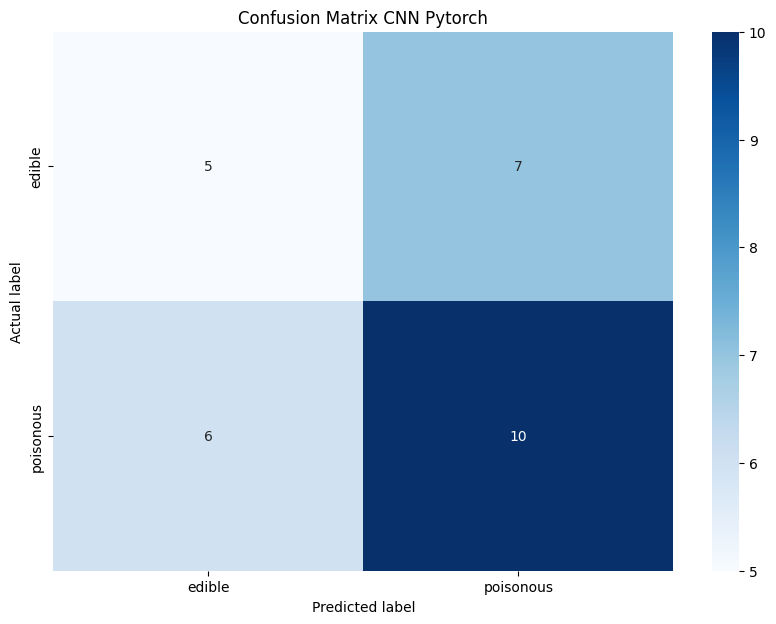

Validation Accuracy: 53.57%

--------------------------------

Classification Report CNN PyTorch:
   Metric    Score
 Accuracy 0.535714
Precision 0.530940
   Recall 0.535714
 F1 Score 0.532656


In [17]:
evaluate_model(model)